In [80]:
import functions_ml as fml
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
# Set font properties globally (Times New Roman and font size 14)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Train

In [81]:
results = pd.read_csv('datasets/instances_results.csv')
features = pd.read_csv('datasets/multi_plant_instance_features.csv')
dataset = fml.create_dataset(features, results)

In [82]:
dataset = fml.create_binary_target(dataset, tolerance=0.01/100)
dataset[['TARGET']].value_counts()

TARGET
GroupA    307
GroupB    291
Name: count, dtype: int64

In [83]:
X = dataset.drop(columns=['TARGET', 'instance'])
X = fml.feature_selection(X)
y = dataset['TARGET']
y = y.replace({'GroupA': 1, 'GroupB': 0}).astype(int)

/tmp/ipykernel_29126/2402756675.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({'GroupA': 1, 'GroupB': 0}).astype(int)


In [84]:
# # Creating the Classifier
# classifier = RandomForestClassifier(random_state=2112)

# # Create Stratified K-Fold for cross-validation
# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=2112)

# # Define the parameter graid
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# # Use F1 score as the evaluation metric
# f1_scorer = make_scorer(f1_score)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(
#     estimator=classifier,
#     param_grid=param_grid,
#     scoring=f1_scorer,
#     cv=cv,
#     n_jobs=-1,
#     verbose=2
# )

# # Fit GridSearchCV
# grid_search.fit(X, y)

# # Use the best model
# classifier = grid_search.best_estimator_

# # Output Best Hyperparameters and Results
# print("Best Hyperparameters:", grid_search.best_params_)
# print("Best Cross-Validated F1 Score:", grid_search.best_score_)

In [85]:
# Best hyperparameters from GridSearchCV
best_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'max_features': 'sqrt',
    'min_samples_leaf': 2,
    'min_samples_split': 10
}

# Classifier with best hyperparameters
classifier = RandomForestClassifier(**best_params, random_state=2112)

# Create Stratified K-Fold for cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=2112)

# Evaluate model using cross-validation
f1_scorer = make_scorer(f1_score)
f1_scores = cross_val_score(classifier, X, y, cv=cv, scoring=f1_scorer)

# Output Cross-Validation Results
print("Cross-Validated F1 Scores:", f1_scores)
print("Mean F1 Score:", f"{np.mean(f1_scores):.4f}")

Cross-Validated F1 Scores: [0.81355932 0.81967213 0.87096774 0.90625    0.83870968 0.875
 0.90909091 0.8        0.84375    0.8115942 ]
Mean F1 Score: 0.8489


In [86]:
# Optional: Cross-validation predictions for confusion matrix and other metrics
predictions = cross_val_predict(classifier, X, y, cv=cv)

# Evaluate metrics based on cross-validated predictions
accuracy = accuracy_score(y, predictions)
precision = precision_score(y, predictions)
recall = recall_score(y, predictions)
f1 = f1_score(y, predictions)
matrix = confusion_matrix(y, predictions)

# Output performance metrics
print(f"Cross-Validated Accuracy: {accuracy:.4f}")
print(f"Cross-Validated Precision: {precision:.4f}")
print(f"Cross-Validated Recall: {recall:.4f}")
print(f"Cross-Validated F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", matrix)

Cross-Validated Accuracy: 0.8395
Cross-Validated Precision: 0.8207
Cross-Validated Recall: 0.8795
Cross-Validated F1 Score: 0.8491
Confusion Matrix:
 [[232  59]
 [ 37 270]]


# Explain

In [87]:
# Train on all data
classifier.fit(X, y)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       random_state=2112)

## Permutation importance

                    Feature  Importance
9          total_setup_cost    0.028070
5             kurt_capacity    0.015478
14  avg_transportation_cost    0.014586
16  iqr_transportation_cost    0.011678
24          p75_utilization    0.009902
7            avg_setup_time    0.009764
11           avg_setup_cost    0.009326
17          min_utilization    0.009181
6               cv_capacity    0.009176
1                num_plants    0.007473
8           kurt_setup_time    0.007268
13          kurt_setup_cost    0.006511
22         kurt_utilization    0.005651
4             skew_capacity    0.005571
19          max_utilization    0.005506
21         skew_utilization    0.005081
15  std_transportation_cost    0.004889
3              std_capacity    0.004408
12          skew_setup_cost    0.004179
10           min_setup_cost    0.003623
18          avg_utilization    0.003100
2               binary_vars    0.002505
23          p25_utilization    0.002092
20          std_utilization    0.001855


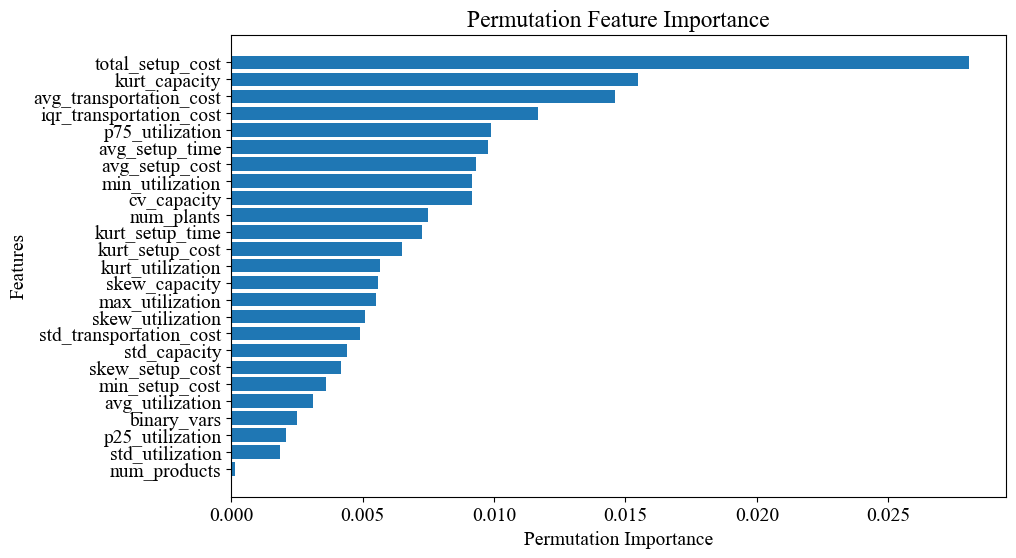

In [88]:
# Compute permutation importance
f1_scorer = make_scorer(f1_score)
perm_importance = permutation_importance(classifier, X, y, scoring=f1_scorer, random_state=2112)

# Create a DataFrame for readability
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

print(importances)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importances['Feature'], importances['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Permutation Importance")
plt.ylabel("Features")
plt.title("Permutation Feature Importance")
plt.show()

## Random forest features

                    Feature  Importance
5             kurt_capacity    0.108321
9          total_setup_cost    0.099260
16  iqr_transportation_cost    0.088227
14  avg_transportation_cost    0.079720
10           min_setup_cost    0.064394
1                num_plants    0.061720
11           avg_setup_cost    0.052653
15  std_transportation_cost    0.049935
17          min_utilization    0.041920
19          max_utilization    0.038356
6               cv_capacity    0.033377
3              std_capacity    0.032372
20          std_utilization    0.029116
2               binary_vars    0.027828
21         skew_utilization    0.023732
13          kurt_setup_cost    0.022622
23          p25_utilization    0.021219
22         kurt_utilization    0.020101
8           kurt_setup_time    0.018781
24          p75_utilization    0.016957
4             skew_capacity    0.015433
7            avg_setup_time    0.014380
12          skew_setup_cost    0.014074
18          avg_utilization    0.012762


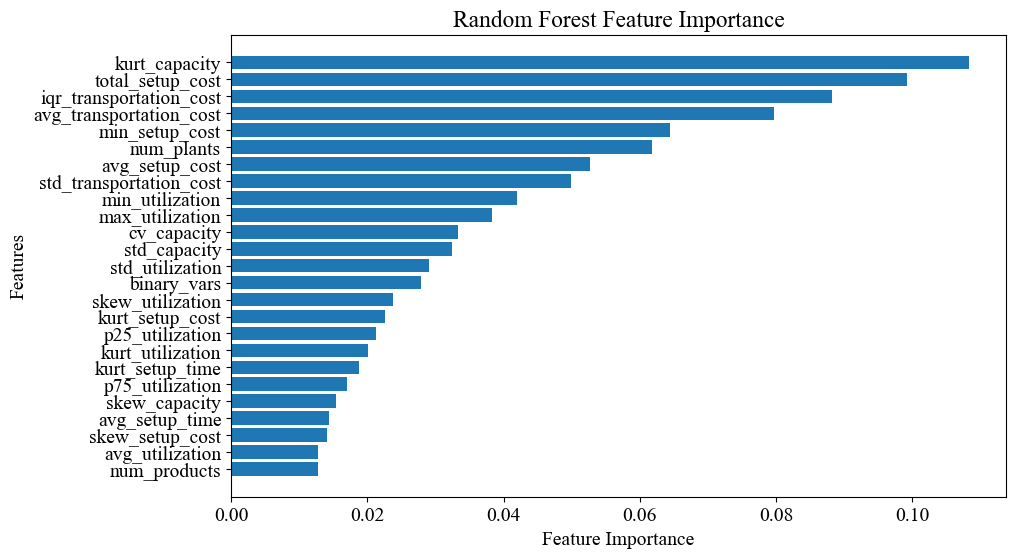

In [89]:
# Extract feature importances
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importances)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importances['Feature'], importances['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.show()

## SHAP

In [90]:
# Initialize SHAP explainer for Tree-based models
explainer = shap.TreeExplainer(classifier)

# Compute SHAP values for all classes
shap_values = explainer.shap_values(X)

# Extract SHAP values for the positive class ('GroupA')
shap_values_binary = shap_values[:, :, 1]  # Focus on class 1

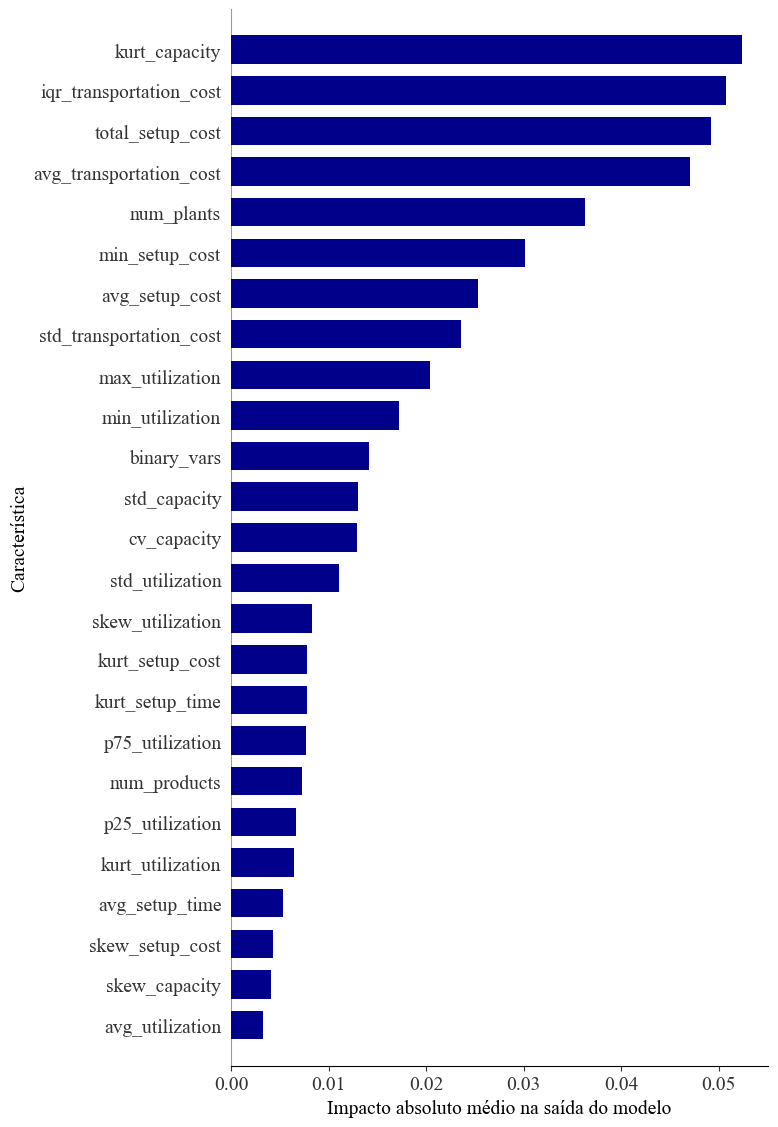

In [91]:
# Customizing the SHAP summary plot
plt.figure(figsize=(10, 8))  # Adjust figure size
shap.summary_plot(
    shap_values_binary, 
    X, 
    plot_type="bar", 
    max_display=30,
    color='darkblue', 
    show=False  # Prevent SHAP from auto-displaying the plot
)

# Customizing axes, fonts, and colors
plt.xlabel("Impacto absoluto médio na saída do modelo", fontsize=14)  # X-axis label customization
plt.ylabel("Característica", fontsize=14)  # Y-axis label customization
plt.xticks(fontsize=14)  # Customize X-axis tick font size
plt.yticks(fontsize=14)  # Customize Y-axis tick font size
# plt.grid(axis='x', linestyle='--', alpha=0.6)  # Add gridlines for X-axis
plt.tight_layout()
plt.savefig('analises/fig_shap_binary_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

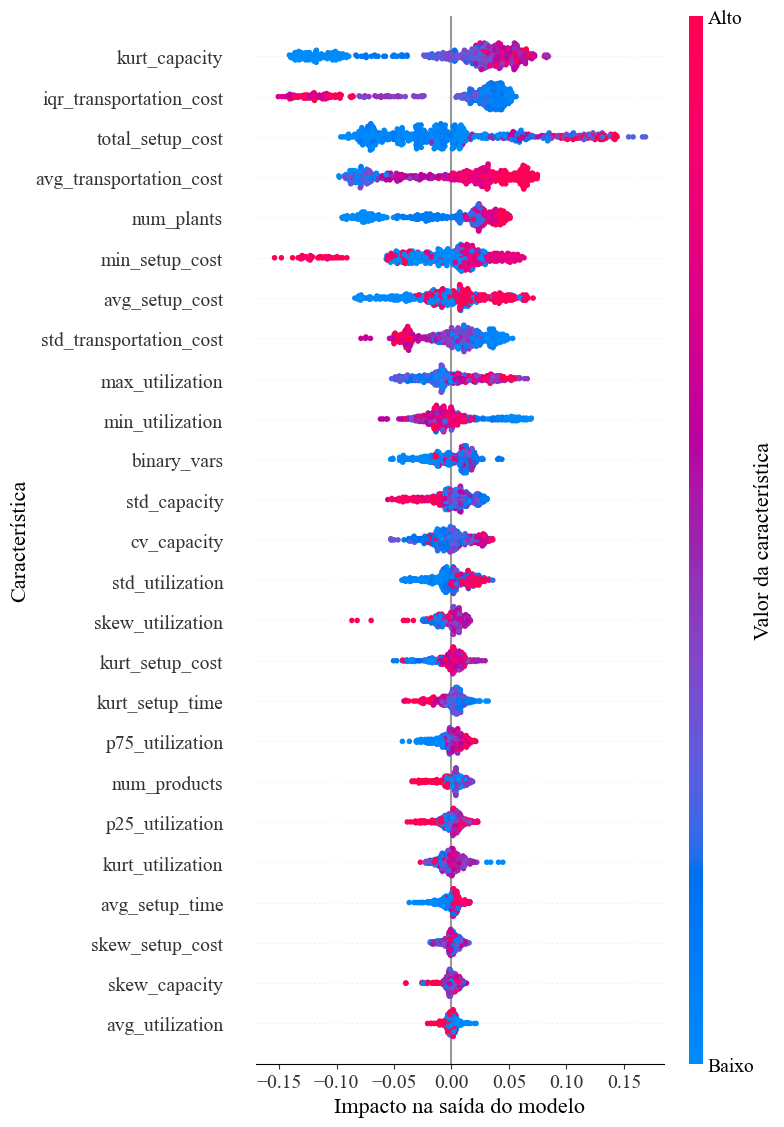

In [92]:
# Generate the SHAP summary plot
plt.figure(figsize=(10, 8))  # Adjust figure size
shap.summary_plot(
    shap_values_binary, 
    X, 
    max_display=30, 
    show=False  # Prevent SHAP from auto-displaying the plot
)

# Access the color bar
cbar = plt.gcf().axes[-1]  # Access the color bar

# Manually set the ticks and labels for the color bar
cbar.set_yticks([0, 1])  # Set the tick positions (corresponding to Low and High)
cbar.set_yticklabels(['Baixo', 'Alto'], fontsize=14)  # Set custom labels for Low and High

# Set the label for the color bar
cbar.set_ylabel("Valor da característica", fontsize=16)  # Rename the color bar label to Portuguese

# Customize additional plot properties
plt.xlabel("Impacto na saída do modelo", fontsize=16)
plt.ylabel("Característica", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.grid(axis='x', linestyle='--', alpha=0.6)  # Add gridlines for X-axis

# Save and show the plot
plt.tight_layout()
plt.savefig('analises/fig_shap_binary_summary.png', dpi=300, bbox_inches='tight')
plt.show()

## Partial dependence plots

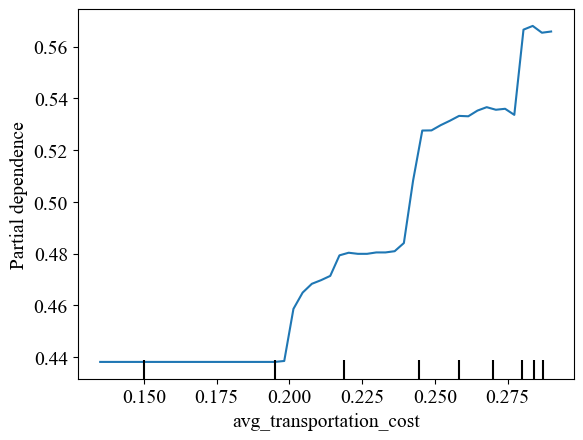

In [93]:
PartialDependenceDisplay.from_estimator(classifier, X, features=['avg_transportation_cost'], kind="average", grid_resolution=50, random_state=2112)
plt.show()

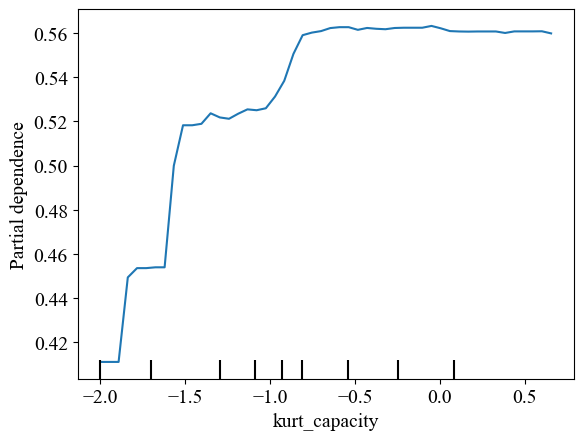

In [94]:
PartialDependenceDisplay.from_estimator(classifier, X, features=['kurt_capacity'], kind="average", grid_resolution=50)
plt.show()

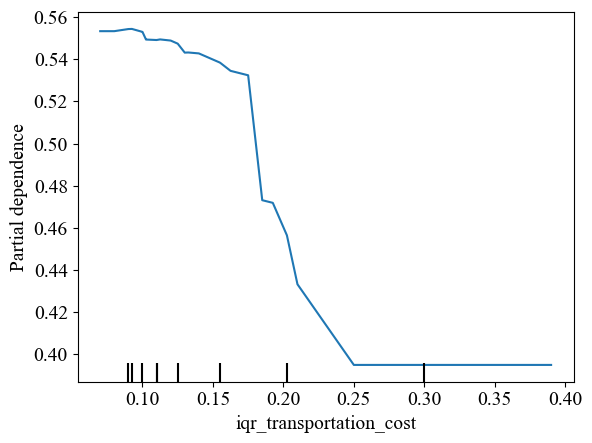

In [95]:
PartialDependenceDisplay.from_estimator(classifier, X, features=['iqr_transportation_cost'], kind="average", grid_resolution=50)
plt.show()

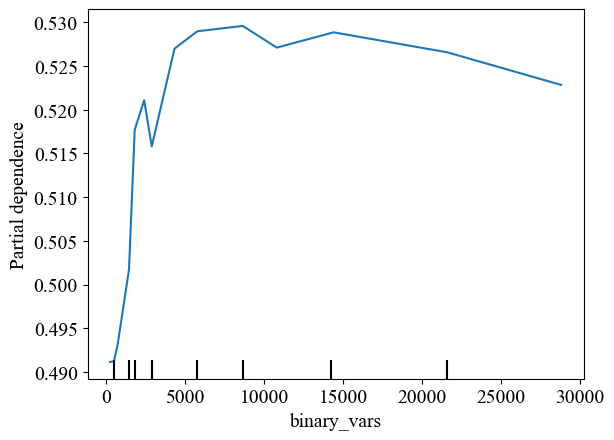

In [96]:
PartialDependenceDisplay.from_estimator(classifier, X, features=['binary_vars'], kind="average", grid_resolution=50)
plt.show()

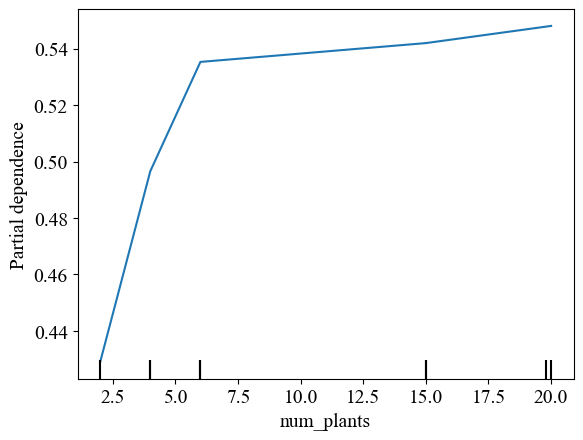

In [97]:
PartialDependenceDisplay.from_estimator(classifier, X, features=['num_plants'], kind="average", grid_resolution=50)
plt.show()

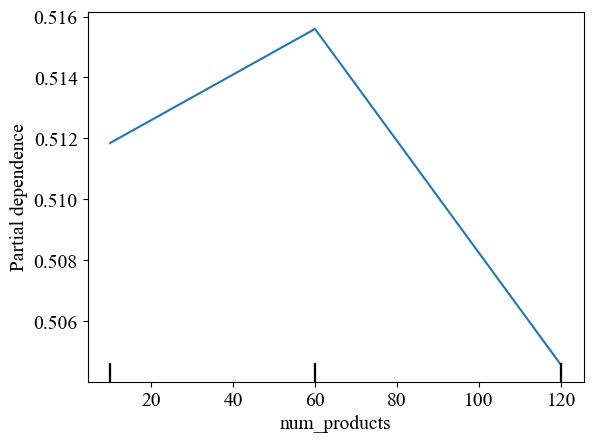

In [98]:
PartialDependenceDisplay.from_estimator(classifier, X, features=['num_products'], kind="average", grid_resolution=50)
plt.show()